In [1]:
%%capture
!pip install mediapipe

In [2]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

In [3]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [4]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

##**Preparing Data**

###**One Image**

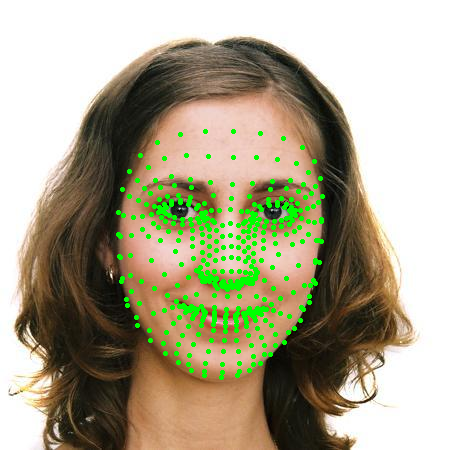

In [5]:
from itertools import count
# choosing random image
random_file = 'image00052'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
 
              #cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)

      cv2_imshow(image)

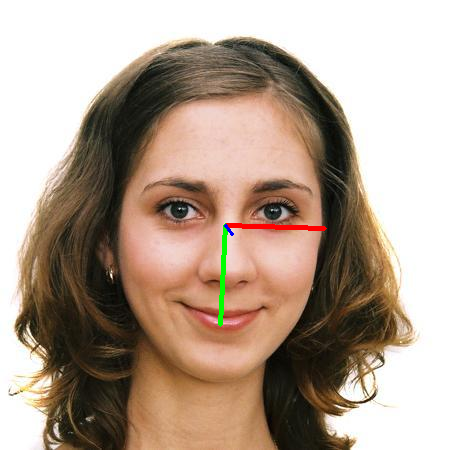

In [6]:
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))

###**Multi_images**

In [7]:
# extracting the file names (2000 name)
file_names = sorted([Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")])

X_points = []
Y_points = []
labels = []
files = []

faceModule = mediapipe.solutions.face_mesh
for filename in file_names:
 with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+filename+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if results.multi_face_landmarks != None: 
      files.append(filename)
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          list_x=[]
          list_y=[]
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              list_x.append(relative_x)
              list_y.append(relative_y)
            
          list_x = np.array(list_x)
          list_y = np.array(list_y)
          X_points.append(list_x)
          Y_points.append(list_y)

          # loading the mat file to extract the labels (pitch,yaw,roll)
          mat_file = sio.loadmat('/content/AFLW2000/'+filename+'.mat')
          # extracting the labels 3 angels
          pose_para = mat_file["Pose_Para"][0][:3]
          # appending the 3 angels to labels list
          labels.append(pose_para)

# converting features and labels to 2D array
X_points = np.array(X_points)
Y_points = np.array(Y_points)
labels = np.array(labels)

pitch_label = labels[:,0]
yaw_label = labels[:,1]
roll_label = labels[:,2]
print(X_points.shape)
print(Y_points.shape)
print(labels.shape)
print(labels)

(1853, 468)
(1853, 468)
(1853, 3)
[[-0.39923078  0.01822658  0.08567622]
 [ 0.47006503  1.18953335  0.30095881]
 [-0.18464977  0.88113666 -0.23685244]
 ...
 [-0.15603451  0.56711417 -0.10853576]
 [-0.19710165 -0.07043044  0.1051178 ]
 [-0.01555222 -0.18012626 -0.02454621]]


In [8]:
# centering the data
Center_X = X_points - X_points[:,99].reshape(-1,1)
Center_Y = Y_points - Y_points[:,99].reshape(-1,1)

X_200 = X_points[:,200]
X_14 = X_points[:,14]
Y_200 = Y_points[:,200]
Y_14 = Y_points[:,14]

#division other points from distance
distance = np.linalg.norm(np.array((X_14,Y_14)) - np.array((X_200,Y_200)),axis = 0).reshape(-1,1)
Norm_X = Center_X / distance
Norm_Y = Center_Y / distance

list_xn = Norm_X
list_yn = Norm_Y
print(list_xn.shape)
print(list_yn.shape)

features = np.hstack([list_xn,list_yn])
print(features.shape)

(1853, 468)
(1853, 468)
(1853, 936)


##**Splitting the data**

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val,file_train,file_test = train_test_split(features,labels,files,test_size = 0.2,random_state = 20)
y_train_pitch = y_train[:,0]
y_train_yaw = y_train[:,1]
y_train_roll = y_train[:,2]
y_val_pitch = y_val[:,0]
y_val_yaw = y_val[:,1]
y_val_roll = y_val[:,2]

##**Pitch Model**

In [10]:
classifier_p = SVR( degree=3 , C=6 , gamma=0.01)

classifier_p = classifier_p.fit(X_train, y_train_pitch)
y_pred = classifier_p.predict(X_train)
y_pred1 = classifier_p.predict(X_val)

print("Train Error: ",mean_absolute_error(y_pred,y_train_pitch))
print('R2 Score: ',classifier_p.score(X_train, y_train_pitch))
print("Validation Error: ",mean_absolute_error(y_pred1,y_val_pitch))
print('R2 Score: ',classifier_p.score(X_val, y_val_pitch))

Train Error:  0.0777701093011559
R2 Score:  0.6432729448869066
Validation Error:  0.11979735730502587
R2 Score:  0.39839397617287875


##**Yaw Model**

In [11]:
classifier_y = SVR( degree=2 , C=4 , gamma=0.01)

classifier_y = classifier_y.fit(X_train, y_train_yaw)
y_pred = classifier_y.predict(X_train)
y_pred1 = classifier_y.predict(X_val)

print("Train Error: ",mean_absolute_error(y_pred,y_train_yaw))
print('R2 Score: ',classifier_y.score(X_train, y_train_yaw))
print("Validation Error: ",mean_absolute_error(y_pred1,y_val_yaw))
print('R2 Score: ',classifier_y.score(X_val, y_val_yaw))

Train Error:  0.06567915957782863
R2 Score:  0.9560819500294448
Validation Error:  0.10187508249267391
R2 Score:  0.9183904401033677


##**Roll Model**

In [12]:
classifier_r = SVR( degree=2 , C=3 , gamma=0.01)

classifier_r = classifier_r.fit(X_train, y_train_roll)
y_pred = classifier_r.predict(X_train)
y_pred1 = classifier_r.predict(X_val)

print("Train Error: ",mean_absolute_error(y_pred,y_train_roll))
print('R2 Score: ',classifier_r.score(X_train, y_train_roll))
print("Validation Error: ",mean_absolute_error(y_pred1,y_val_roll))
print('R2 Score: ',classifier_r.score(X_val, y_val_roll))

Train Error:  0.07578447963828522
R2 Score:  0.4661089821900718
Validation Error:  0.11038980736654808
R2 Score:  0.4932379985340235


###**One image (Testing)**

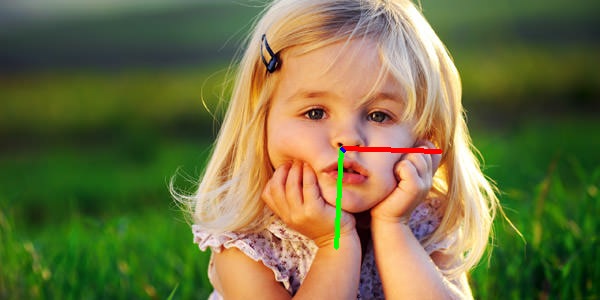

In [13]:
# choosing random image from the testing data
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  # reading the image
  frame = cv2.imread("/content/little-girl.jpg")
  # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
  results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        # initializing two lists to store x and y points
        list_x = []
        list_y = []
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            
            shape = frame.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            
            list_x.append(relative_x)
            list_y.append(relative_y)
      
        list_x = np.array(list_x)
        list_y = np.array(list_y)
        X_center = list_x - list_x[99]
        Y_center = list_y - list_y[99]

        d = np.linalg.norm(np.array((list_x[200],list_y[200])) - np.array((list_x[14],list_y[14])))
        X_norm = X_center/d
        Y_norm = Y_center/d
        X_norm = X_norm
        Y_norm = Y_norm

        list_all = np.hstack([X_norm,Y_norm]).reshape(1,-1)
        # predicting the 3 angels to draw the axis on the image
        pred_pitch = classifier_p.predict(list_all)
        pred_yaw = classifier_y.predict(list_all)
        pred_roll = classifier_r.predict(list_all)
        cv2_imshow(draw_axis(frame,pred_pitch,pred_yaw,pred_roll,list_x[99],list_y[99]))

###**Video Testing**

In [14]:
cap = cv2.VideoCapture('/content/VideoTest.mp4')
width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('HeadPose.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 30, (width,height))

if (cap.isOpened()== False): 
    print("Error opening video file")
  
imgs = []
while(cap.isOpened()):   
    ret, frame = cap.read()
    if ret == True:
      with faceModule.FaceMesh(static_image_mode=True) as face:
        # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
        results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None:
          for face in results.multi_face_landmarks:
              list_xv = []
              list_yv = []
              # looping over the landmarks to extract x and y
              for j,landmark in enumerate(face.landmark):
                  x = landmark.x
                  y = landmark.y
                  
                  shape = frame.shape 
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  list_xv.append(relative_x)
                  list_yv.append(relative_y)

              list_xv = np.array(list_xv)
              list_yv = np.array(list_yv)
              X_center = list_xv - list_xv[99]
              Y_center = list_yv - list_yv[99]
              d = np.linalg.norm(np.array((list_xv[200],list_yv[200])) - np.array((list_xv[14],list_yv[14])))
              X_norm = X_center/d
              Y_norm = Y_center/d
              X_norm = X_norm
              Y_norm = Y_norm
              list_all = np.hstack([X_norm,Y_norm]).reshape(1,-1)
 
              pred_pitch = classifier_p.predict(list_all)
              pred_yaw = classifier_y.predict(list_all)
              pred_roll = classifier_r.predict(list_all)
              #print(pred_pitch)
              #print(pred_yaw)
              #print(pred_roll)

              draw_axis(frame,pred_pitch,pred_yaw,pred_roll,list_xv[99],list_yv[99])
              imgs.append(frame)

    # Break the loop
    else: 
        break

cap.release()  
cv2.destroyAllWindows()

In [15]:
for i in range(len(imgs)):
    out.write(imgs[i])
out.release()